In [56]:
import numpy as np

emission_data = np.load("emission_data_2021-2023.npy", allow_pickle=True)

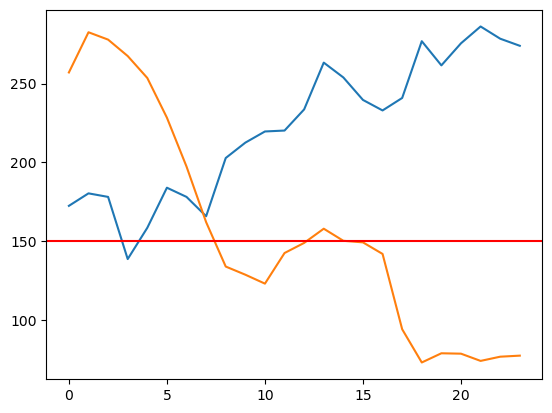

In [57]:
import matplotlib.pyplot as plt

idx_1 = 401
idx_2 = 1000


time_period = window_size = 0
min_interval = 1
max_emission_value = 150


first_forecast = emission_data[idx_1 : idx_1 + 24]
second_forecast = emission_data[idx_2 : idx_2 + 24]

extended_first_forecast = emission_data[idx_1 - window_size : idx_1 + 24]
extended_second_forecast = emission_data[idx_2 - window_size: idx_2 + 24]

first_forecast.shape, extended_first_forecast.shape


plt.plot(first_forecast)
plt.plot(second_forecast)
plt.axhline(y=max_emission_value, c='r')

In [58]:
forecasts = np.stack([first_forecast, second_forecast])

In [59]:
min_step_size = 1
max_window_size = 3

time_slots = np.zeros((len(forecasts), 24))


for forecast_id, forecast in enumerate(forecasts):
    for window_size in range(max_window_size):
        for i in range(len(forecast)):
            co2_mean = forecast[i : i + min_step_size + window_size].mean()
            if co2_mean < max_emission_value:
                time_slots[forecast_id, i : i + min_step_size + window_size - 1] = 1
time_slots

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]])

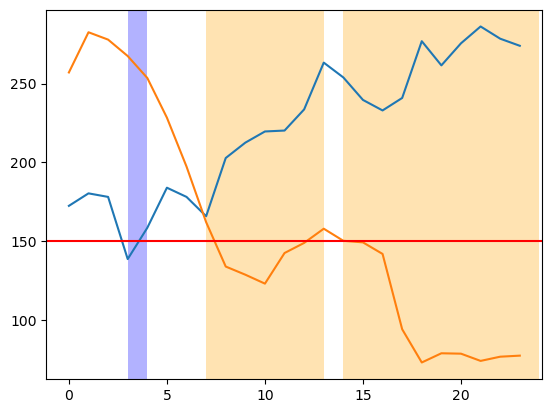

In [69]:
from matplotlib.patches import Rectangle

plt.plot(first_forecast)
plt.plot(second_forecast)
plt.axhline(y=max_emission_value, c='r')

for i in range(len(time_slots[0])):
    if time_slots[0][i] == 1:
        plt.gca().add_patch(Rectangle((i,0),1,300, facecolor='blue', alpha=0.3 ))

for i in range(len(time_slots[1])):
    if time_slots[1][i] == 1:
        plt.gca().add_patch(Rectangle((i,0),1,300, facecolor='orange', alpha=0.3 ))


In [70]:
time_slots_vms = np.ones((24), dtype=int) * -1
for i in range(24):
    if time_slots[:, i].sum() == 0:
        continue
    if time_slots[:, i].sum() == 1:
        time_slots_vms[i] = time_slots[:, i].argmax() 
    else:
        min_co2_idx = forecasts[:, i].argmin()
        time_slots_vms[i] = min_co2_idx 

In [71]:
time_slots_vms

array([-1, -1, -1,  0, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1])

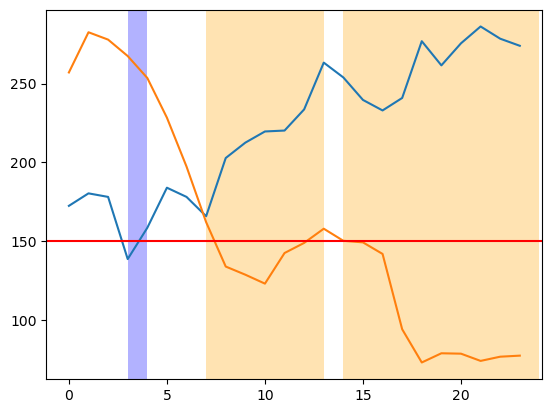

In [72]:
from matplotlib.patches import Rectangle

plt.plot(first_forecast)
plt.plot(second_forecast)
plt.axhline(y=max_emission_value, c='r')

for i in range(len(time_slots[0])):
    if time_slots_vms[i] == 0:
        plt.gca().add_patch(Rectangle((i,0),1,300, facecolor='blue', alpha=0.3 ))
    elif time_slots_vms[i] == 1:
        plt.gca().add_patch(Rectangle((i,0),1,300, facecolor='orange', alpha=0.3 ))

In [73]:
current_vm = -1

intervals = {}
for time, vm in enumerate(time_slots_vms):
    if current_vm == -1:
        current_vm = vm
        start_time = time
    
    if vm != current_vm:
        end_time = time
        if current_vm in intervals.keys():
            intervals[current_vm].append((start_time, end_time))
        else:
            intervals[current_vm] = [(start_time, end_time)]
        current_vm = vm
        start_time = time

else:
    end_time = time
    if current_vm in intervals.keys():
        intervals[current_vm].append((start_time, end_time))
    else:
        intervals[current_vm] = [(start_time, end_time)]


In [74]:
intervals

{0: [(3, 4)], 1: [(7, 13), (14, 23)]}

In [76]:
import datetime
datetime_intervals = {k : [
            (
                datetime.datetime.now(datetime.timezone.utc).replace(
                    minute=0, second=0, microsecond=0
                )
                + datetime.timedelta(hours=int(jstart)),
                datetime.datetime.now(datetime.timezone.utc).replace(
                    minute=0, second=0, microsecond=0
                )
                + datetime.timedelta(hours=int(jend)),
            )
            for jstart, jend in intervals[k]
        ] for k in intervals.keys()}

In [77]:
datetime_intervals

{0: [(datetime.datetime(2023, 6, 21, 13, 0, tzinfo=datetime.timezone.utc),
   datetime.datetime(2023, 6, 21, 14, 0, tzinfo=datetime.timezone.utc))],
 1: [(datetime.datetime(2023, 6, 21, 17, 0, tzinfo=datetime.timezone.utc),
   datetime.datetime(2023, 6, 21, 23, 0, tzinfo=datetime.timezone.utc)),
  (datetime.datetime(2023, 6, 22, 0, 0, tzinfo=datetime.timezone.utc),
   datetime.datetime(2023, 6, 22, 9, 0, tzinfo=datetime.timezone.utc))]}